In [90]:
import pandas as pd
import glob

In [91]:
path = r'00_source_data/cause_of_death' # point to correct folder
filenames = glob.glob(path + "/*.txt") # select all text files in folder

df = pd.DataFrame() # empty df - will store data from all txt files

for f in filenames:
    temp = pd.read_csv(f, index_col=None, header=0, sep='\t')
    # we're getting some extraneous notes at the bottom - let's just drop based on county as these will only be null for these useless notes columns
    temp.dropna(subset={'County'}, inplace=True)
    
    df = pd.concat([df, temp], axis=0, ignore_index=True)

In [92]:
# helper functions to separate county and state

def abtract_state(county):
    """
    Args:
        county (str): county name

    Returns:
        str: state
    """
    return county.split(", ")[1]



def abstract_county(county):
    """
    Args:
        county (str): county name

    Returns:
        str: county
    """
    return county.split(", ")[0]

# apply functions to our df
df["State"] = df.apply(lambda x: abtract_state(x["County"]), axis=1)
df["County"] = df.apply(lambda x: abstract_county(x["County"]), axis=1)

# do not need notes column, let's just drop it here
df.drop(columns={"Notes"}, inplace=True)

df_cause_of_death = df.copy() # keep a copy of this df for later filtering

In [93]:
# function to select only overdose records
# double check this

def select_overdose(record):
    """Simple function to select only overdose records"""

    if record == "All other non-drug and non-alcohol causes":
        return 0

    if record == "All other alcohol-induced causes":
        return 0

    if record == "All other drug-induced causes":
        return 0

    if record == "Alcohol poisonings (overdose) (X45, X65, Y15)":
        return 0

    if record == "Drug poisonings (overdose) Unintentional (X40-X44)":
        return 1

    if record == "Drug poisonings (overdose) Suicide (X60-X64)":
        return 1

    if record == "Drug poisonings (overdose) Undetermined (Y10-Y14)":
        return 1

    else:
        return "error"
    

# apply to cause of death
df_cause_of_death["overdose"] = df_cause_of_death["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))

In [94]:
df_cause_of_death = df_cause_of_death[df_cause_of_death["overdose"] == 1]

In [95]:
df_cause_of_death[df_cause_of_death["Deaths"] == "Missing"].head()
# interesting case where death data is missing. These will either have to be imputed or dropped if we use AK as a comparison state

,County,County Code,Year,Year Code,Drug/Alcohol Induced Cause,Drug/Alcohol Induced Cause Code,Deaths,State,overdose
52576,Prince of Wales-Outer Ketchikan Census Area,2201.0,2015.0,2015.0,Drug poisonings (overdose) Unintentional (X40-...,D1,Missing,AK,1
52577,Prince of Wales-Outer Ketchikan Census Area,2201.0,2015.0,2015.0,Drug poisonings (overdose) Suicide (X60-X64),D2,Missing,AK,1
52579,Prince of Wales-Outer Ketchikan Census Area,2201.0,2015.0,2015.0,Drug poisonings (overdose) Undetermined (Y10-Y14),D4,Missing,AK,1
52585,Skagway-Hoonah-Angoon Census Area,2232.0,2015.0,2015.0,Drug poisonings (overdose) Unintentional (X40-...,D1,Missing,AK,1
52586,Skagway-Hoonah-Angoon Census Area,2232.0,2015.0,2015.0,Drug poisonings (overdose) Suicide (X60-X64),D2,Missing,AK,1


In [96]:
# for now, let's drop them

df_cause_of_death = df_cause_of_death[df_cause_of_death["Deaths"] != "Missing"]

In [97]:
df_cause_of_death["Deaths"] = df_cause_of_death["Deaths"].apply(lambda x: float(x))
df_cause_of_death["DeaYearths"] = df_cause_of_death["Year"].apply(lambda x: int(x))

In [98]:
# set max display rows to 100
pd.set_option('display.max_rows', None)

In [99]:
overdoses_by_state_and_year = df_cause_of_death.groupby(["State", "Year"]).Deaths.sum().reset_index().sort_values("Deaths", ascending=False)
overdoses_by_state = df_cause_of_death.groupby(["State"]).Deaths.sum().reset_index().sort_values("Deaths", ascending=False)

## Finding candidate comparison states for each target state
- by looking through both dataframes above, we've determined a handful of candidate states that we can compare each target state to. First, we looked at overdoses_by_state_and_year to see which states were close to our target states frequently. Then, we looked only at the overdoses_by_state to determine, more generally, which states may be similar. Upon plotting these smaller subsets of states, we look to find the best matches for comparison.

- Florida
    - CA, PA, OH, NY, MA, IL
<br><br>
- Texas
    - PA, NY, OH, MA, IL, MI, AZ
<br><br>
- Washington
    - AZ, GA, NC, MD, TN, CO

In [100]:
#fl = ["FL", "PA", "OH", "NY", "MA", "IL"]
fl = ["FL", "OH", "NC", "MI", "NY", "MA", "PA"]
tx = ["TX", "PA", "NY", "OH", "MA", "IL", "MI", "AZ"]
wa = ["WA", "AZ","GA", "NC", "MD", "TN", "CO"]


In [101]:
fl_comp = overdoses_by_state_and_year[overdoses_by_state_and_year["State"].isin(fl)]
tx_comp = overdoses_by_state_and_year[overdoses_by_state_and_year["State"].isin(tx)]
wa_comp = overdoses_by_state_and_year[overdoses_by_state_and_year["State"].isin(wa)]

### Florida Comparison States

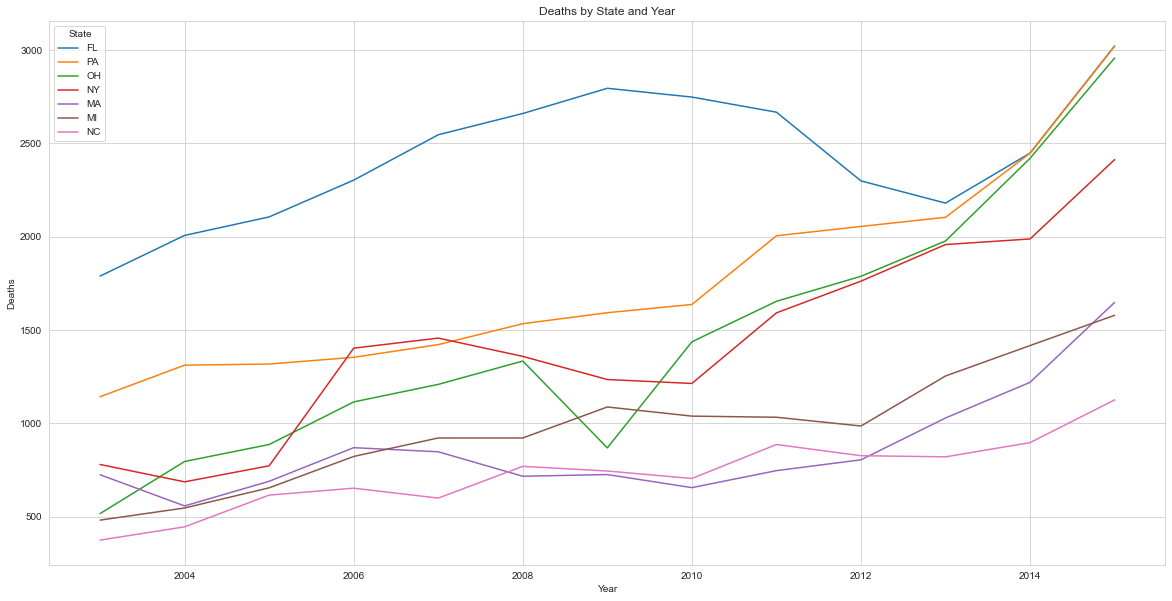

In [102]:
# plot deaths across years for every state
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=fl_comp, x="Year", y="Deaths", hue="State", markers = True)
plt.title("Deaths by State and Year")

plt.show()


For Florida, we can see loosely similar trends in PA, MI, and NC. Let's look just at these states to confirm.

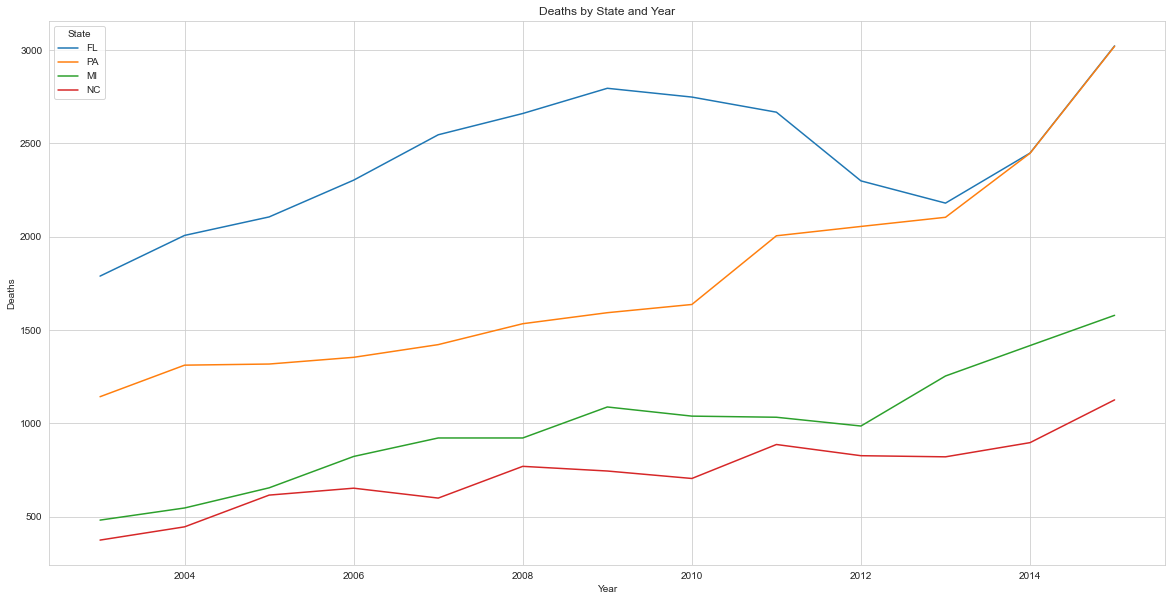

In [104]:
# plot deaths across years for every state
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=fl_comp[fl_comp["State"].isin(["PA", "MI", "NC", "FL"])], x="Year", y="Deaths", hue="State", markers = True)
plt.title("Deaths by State and Year")

plt.show()


### Texas Comparison States

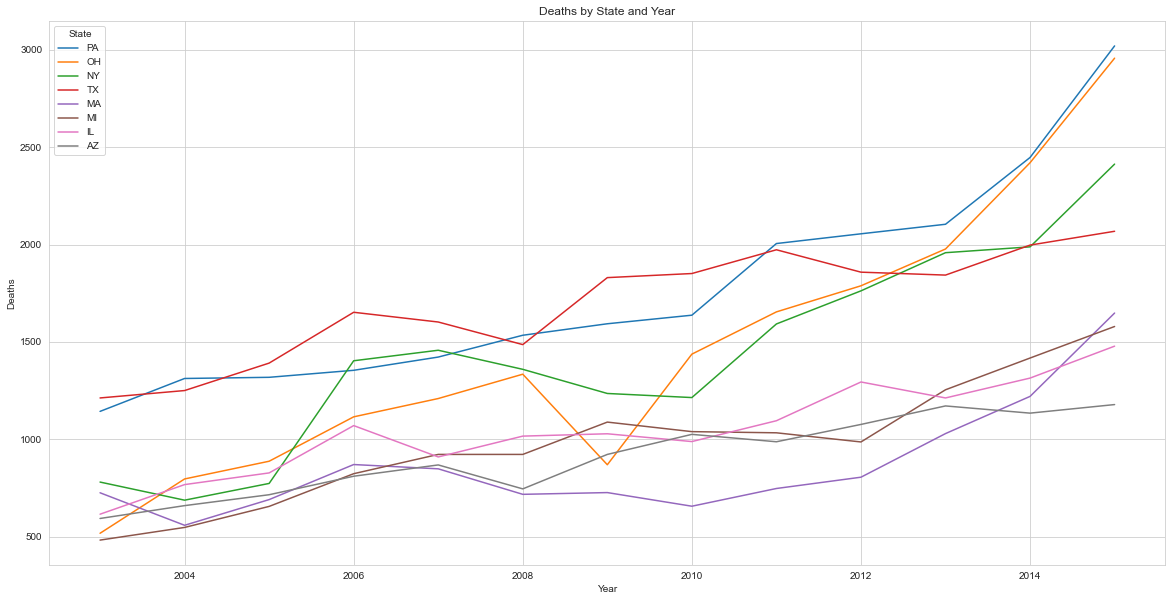

In [ ]:
# plot deaths across years for every state
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=tx_comp, x="Year", y="Deaths", hue="State", markers = True)
plt.title("Deaths by State and Year")

plt.show()


We can see that the set of IL, MA, and MI exhibit similar trends across time for overdose deaths (albeit this is a little tough to see with all the lines). Let's plot just this subset to get a clearer view.

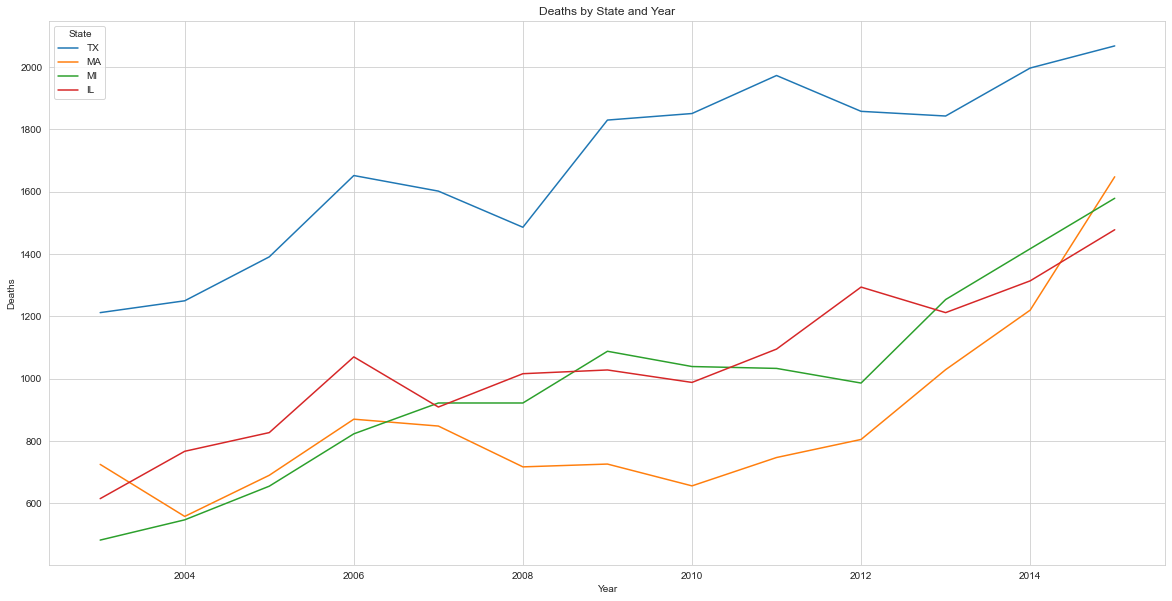

In [ ]:
# plot deaths across years for every state
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=tx_comp[tx_comp["State"].isin(["TX", "IL", "MA", "MI"])], x="Year", y="Deaths", hue="State", markers = True)
plt.title("Deaths by State and Year")

plt.show()

While the overdose deaths for these comparison states are all considerably lower than those of Texas, we can see that their trends are generally the same.


### Washington Comparison States

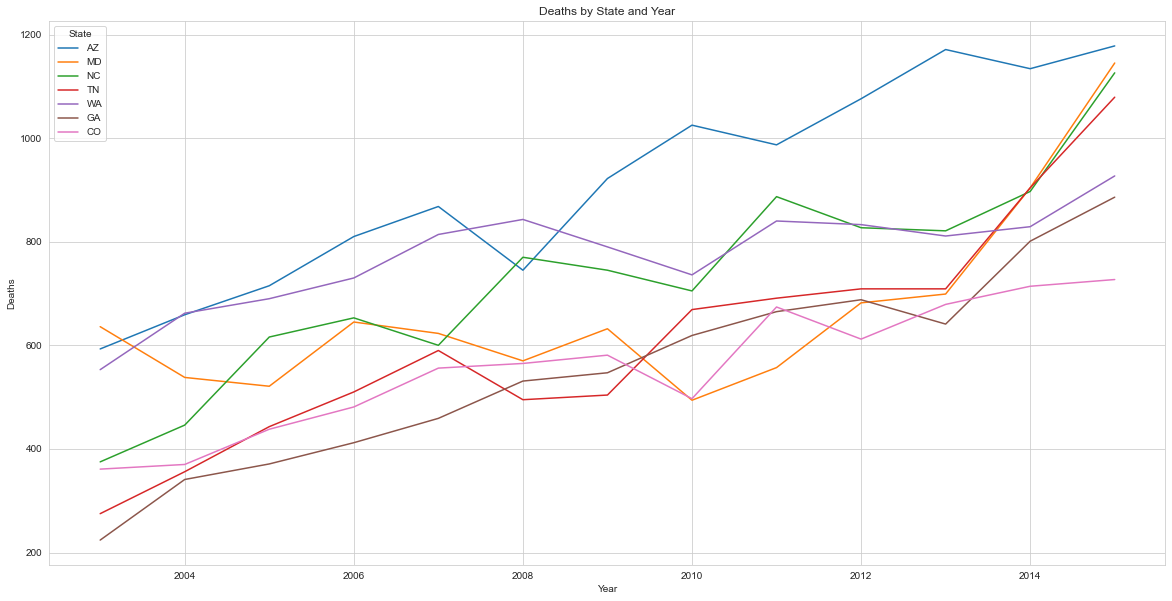

In [ ]:
# plot deaths across years for every state
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=wa_comp, x="Year", y="Deaths", hue="State", markers = True)
plt.title("Deaths by State and Year")

plt.show()


Based on the above chart, our best bet for Washington comparison states are NC, CO, and MD. Again, let's isolate these states just for confirmation.

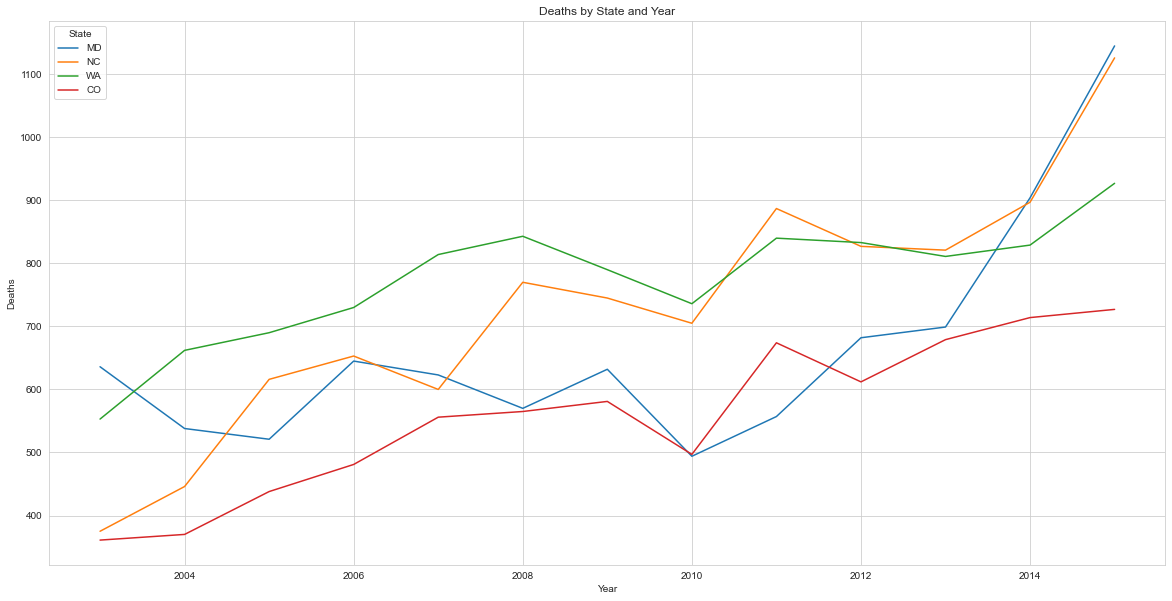

In [105]:
# plot deaths across years for every state
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=wa_comp[wa_comp["State"].isin(["WA", "NC", "CO", "MD"])], x="Year", y="Deaths", hue="State", markers = True)
plt.title("Deaths by State and Year")

plt.show()
